
# Master code for 200B water column (vertical) cases
    Original MATLAB code from Lisa Lucas, modified by Tina Chow.
    Spring 2018: Mark Stacey and Michaella Chung.
    Adapted to Python by Alexandre Georges, Spring 2022.


In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Define model set up - grid and timestep

In [31]:
N=80 # number of grid points
H=20 # depth (meters)
dz=H/N # grid spacing - may need to adjust to reduce oscillations
dt=60 # (seconds) size of time step 
M=2000 # number of time steps 
# M=1440; # number of time steps 
beta = (dt/dz**2)
z = np.zeros(N)
for i in range(N): # Initialize grid
   z[i]=-H+dz*(i) # bottom at z=-H, free surface at 0
isave=100 #increments for saving profiles. set to 1 to save all; 10 saves every 10th, etc. 
savecount=1

## Water Column Setup

###  Initialize all profiles and closure parameters 
      Call once before time loop
      Sets all forcing: pressure gradients, stresses, etc.
      Should be used to adjust initial temperature/salinity profiles
      Velocity initialized to zero
      Turbulence quantities initialized to "SMALL"; Lengthscale parabolic


In [32]:

# Physical parameters 
z0=0.01 #bottom roughness [m]
zb=10*z0 #bottom height
g=9.81 #m^2/s - gravity
C_D = 0.0025 #friction coefficient
SMALL=1e-6
kappa=0.4 #von Karman constant
nu=1e-6 #m^2/s kinematic viscosity


# Forcing parameters - Need to modify to allow for time variable Px.
Px0 = .001 #Magnitude on pressure gradient forcing
T_Px = 12.0 #Period (hours) on pressure gradient forcing. Set to 0 for steady

# Turbulence closure parameters 
A1=0.92
A2=0.74
B1=16.6
B2=10.1
C1=0.08
E1=1.8
E2= 1.33
E3=0.25
Sq=0.2 

# Setup initial conditions for scalar and density
delC = 5    #change in temperature at initial themocline [deg C]; set to zero for Unstratified Case
zdelC = -5  #position of initial thermocline
dzdelC = -2 #width of initial thermocline
alpha = 0.000214 #thermal expansivity, set to zero for passive scalar case 
rho0 = 1000      #kg/m^3 - water density
C = np.zeros(N)
rho = np.zeros(N)
N_BV = np.zeros(N)
U = np.zeros(N)
V = np.zeros(N)

for i in range(N):
  C[i] = 15
  if z[i] <= zdelC - 0.5*dzdelC:
    C[i] = 15
  elif z[i] >= zdelC + 0.5*dzdelC:
    C[i] = 15 + delC
  else:
    C[i] = 15 + delC*(z[i] - zdelC + 0.5*dzdelC)/dzdelC
  rho[i] = rho0*(1 - alpha*(C[i] - 15))  # Single scalar, linear equation of state
# Brunt-Vaisala Frequency from density profile
N_BV[0] = math.sqrt((-g/rho0)*(rho[1]-rho[0])/(dz))
for i in range(1,N-1):
  N_BV[i] = math.sqrt((-g/rho0)*(rho[i+1] - rho[i])/(dz))
N_BV[N-1] = math.sqrt((-g/rho0)*(rho[N-1] - rho[N-2])/(dz))


# Set initial conditions for u, q^2, and other turbulence quantities
Up = np.zeros(N)
Vp = np.zeros(N)
Q2 = SMALL*np.ones(N) # "seed" the turbulent field with small values, then let it evolve
Q2L = SMALL*np.ones(N)
Q = np.zeros(N)
L = -kappa*H*(z/H)*(1-(z/H)) # Q2L(n,1)/Q2(n,1) = 1 at initialization
Sm = np.zeros(N)
Sh = np.zeros(N)
nu_t = np.zeros(N)
Kq = np.zeros(N)
Kz = np.zeros(N)

for i in range(N):
  if z[i] <= -2:
    U[i] = 15
  else:
    U[i] = 0.1*(z[i] + 2)
  Q[i] = math.sqrt(Q2[i])
  Gh = -((N_BV[i]*L[i])/(Q[i] + SMALL))**2
  Gh = min(Gh, 0.0233)
  Gh = max(Gh, -0.28)        
  num= B1**(-1/3) - A1*A2*Gh*((B2-3*A2)*(1-6*A1/B1)-3*C1*(B2+6*A1))
  dem= (1-3*A2*Gh*(B2+6*A1))*(1-9*A1*A2*Gh)
  Sm[i] = num/dem
  Sh[i] = A2*(1-6*A1/B1)/(1-3*A2*Gh*(B2+6*A1))
  nu_t[i] = Sm[i] * Q[i] * L[i] + nu # Turbulent diffusivity for Q2
  Kq[i] = Sq*Q[i]*L[i] + nu # Turbulent viscosity
  Kz[i] = Sh[i] * Q[i] * L[i] + nu # Turbulent scalar diffusivity


# Pre-define Tridiagonal Arrays - Just in case
aC = np.zeros(N)
bC = np.zeros(N)
cC = np.zeros(N)
dC = np.zeros(N)
aQ2 = np.zeros(N)
bQ2 = np.zeros(N)
cQ2 = np.zeros(N)
dQ2 = np.zeros(N)
aQ2L = np.zeros(N)
bQ2L = np.zeros(N)
cQ2L = np.zeros(N)
dQ2L = np.zeros(N)


#  Save initial conditions as first columns in saved matrix
n_profiles = int(M/isave)
Cm = np.zeros((N,n_profiles))
Q2m = np.zeros((N,n_profiles))
Q2Lm = np.zeros((N,n_profiles))
rhom = np.zeros((N,n_profiles))
Lm = np.zeros((N,n_profiles))
nu_tm = np.zeros((N,n_profiles))
Kzm = np.zeros((N,n_profiles))
Kqm = np.zeros((N,n_profiles))
N_BVm = np.zeros((N,n_profiles))

Cm[:,1] = C
Q2m[:,1] = Q2
Q2Lm[:,1] = Q2L
rhom[:,1] = rho
Lm[:,1] = L
nu_tm[:,1] = nu_t
Kzm[:,1] = Kz
Kqm[:,1] = Kq
N_BVm[:,1] = N_BV

## Time-advancing algorithm
    Steps a single timestep for c, rho, q2, q2l, l, kz, nu_t, kq
    All diffusion/viscous terms handled implicitly

TDMA Solver

In [33]:
def TDMA(aX, bX, cX, dX, N):
    x = np.zeros(N)
    for i in range(1, N):
        bX[i] = bX[i] - aX[i]/bX[i-1]*cX[i-1]
        dX[i] = dX[i] - aX[i]/bX[i-1]*dX[i-1]
    x[-1] = dX[-1]/bX[-1]
    for i in range(N-2, -1, -1):
        x[i] = (1/bX[i])*(dX[i] - cX[i]*x[i+1])
    return x

Time-Advancement

In [34]:
def wc_advance(U, C, Q2, Q2L, rho, L, nu_t, Kz, Kq, N_BV):
    Px = np.zeros(N)
    #  Update pressure forcing term for the current timestep
    for i in range(N):
        if T_Px == 0.0:
            Px[i] = Px0  # Steady and constant forcing for now
        else:
            Px[i] = Px0*math.cos(2*math.pi*t[m]/(3600.*T_Px))

    #Update shear velocity at bottom boundary for use later
    ustar = abs(U[1])*math.sqrt(C_D); # Explicit dependence on C_D


    # Update parameters for the model, Sm and Sh

    for i in range(N):		
        Gh=-(N_BV[i]*L[i]/(Q[i]+SMALL))**2 
        # set LIMITER for Gh 
        Gh=min(Gh, 0.0233)
        Gh=max(Gh, -0.28)
        num=B1**(-1/3)-A1*A2*Gh*((B2-3*A2)*(1-6*A1/B1)-3*C1*(B2+6*A1))
        dem=(1-3*A2*Gh*(B2+6*A1))*(1-9*A1*A2*Gh)
        Sm[i]=num/dem
        Sh[i]=A2*(1-6*A1/B1)/(1-3*A2*Gh*(B2+6*A1)) 


    #  Place previous variable f into fp (i.e. q2 into q2p, etc)
    Cp = C
    Q2p = Q2
    Q2Lp = Q2L
    Lp = L
    Kzp = Kz
    nu_tp = nu_t
    Kqp = Kq
    N_BVp = N_BV


    # Advance scalars/density (C, rho) 
    for i in range(1, N-1):
        aC[i] = -0.5*beta*(Kzp[i] + Kzp[i-1])
        bC[i] = 1+0.5*beta*(Kzp[i+1] + 2*Kzp[i+1] + Kzp[i-1])
        cC[i] = -0.5*beta*(Kzp[i] + Kzp[i+1])
        dC[i] = Cp[i]
    # Bottom-Boundary: no flux for scalars
    bC[0] = 1+0.5*beta*(Kzp[1] + Kzp[0])
    cC[0] = -0.5*beta*(Kzp[1] + Kzp[0])
    dC[0] =  Cp[0]
    # Top-Boundary: no flux for scalars
    aC[-1] = -0.5*beta*(Kzp[-1] + Kzp[N-2])
    bC[-1] = 1+0.5*beta*(Kzp[-1] + Kzp[N-2])
    dC[-1] = Cp[-1]
    # TDMA to solve for C
    C = TDMA(aC, bC, cC, dC, N)
    #update density and Brunt-Vaisala frequency
    for i in range(N):
        rho[i] = rho0*(1-alpha*(C[i] - 15))
    N_BV[0] = math.sqrt(abs(((-g/rho0)*(rho[1]-rho[0])/dz)))
    for i in range(1, N-1):
        N_BV[i] = math.sqrt(abs((-g/rho0)*(rho[i+1] - rho[i-1])/(2*dz)))
    N_BV[-1] = math.sqrt(abs((-g/rho0)*(rho[-1] - rho[N-2])/dz))


    #  Advance turbulence parameters (q2, q2l - q2 first, then q2l)
    for i in range(1, N-1):
            diss = (2 * dt *(Q2p[i]**0.5))/(B1*Lp[i]) # Coefficient for linearized term
            aQ2[i] = -0.5*beta*(Kqp[i] + Kqp[i-1])
            bQ2[i] = 1+0.5*beta*(Kqp[i+1] + 2*Kqp[i] + Kqp[i-1]) + diss
            cQ2[i] = -0.5*beta*(Kqp[i] + Kqp[i+1])
            dQ2[i] = Q2p[i] + 0.25*beta*nu_tp[i]*(Up[i+1]-Up[i-1])**2 -dt*Kzp[i]*(N_BVp[i]**2)
    # Bottom-Boundary Condition 
    Q2bot = B1**(2/3) * ustar**2
    bdryterm = 0.5*beta*Kqp[0]*Q2bot
    diss =  2 * dt *((Q2p[0]**0.5)/(B1*Lp[0]))
    bQ2[0] = 1+0.5*beta*(Kqp[1] + Kqp[0]) + diss
    cQ2[0] = -0.5*beta*(Kqp[1] + Kqp[0])
    dQ2[0] = Q2p[0] + dt*((ustar**4)/nu_tp[0]) - dt*Kzp[0]*(N_BVp[0]**2) + bdryterm
    # Top-Boundary Condition
    diss =  2 * dt *((Q2p[-1]**0.5)/(B1*Lp[-1]))
    aQ2[-1] = -0.5*beta*(Kqp[-1] + Kqp[N-2])
    bQ2[-1] = 1+0.5*beta*(Kqp[-1] + 2*Kqp[-1] + Kq[N-2]) + diss
    dQ2[-1] = Q2p[-1] + 0.25*beta*nu_tp[-1]*((Up[-1] - Up[N-2])**2) -4*dt*Kzp[-1]*(N_BVp[-1]**2)
    # TDMA to solve for q2
    Q2 = TDMA(aQ2, bQ2, cQ2, dQ2, N)
    # Kluge to prevent negative values from causing instabilities
    for i in range(N):
        if Q2[i] < SMALL:
            Q2[i] = SMALL

    for i in range(1, N-1):
            diss = 2*dt*((Q2p[i]**0.5) / (B1*Lp[i]))*(1+E2*(Lp[i]/(kappa*abs(-H-z[i])))**2 + E3*(Lp[i]/(kappa*abs(z[i])))**2)
            aQ2L[i] = -0.5*beta*(Kqp[i] + Kqp[i-1])
            bQ2L[i] = 1+0.5*beta*(Kqp[i+1] + 2*Kqp[i] + Kqp[i-1]) + diss
            cQ2L[i] = -0.5*beta*(Kqp[i] + Kqp[i+1])
            dQ2L[i] = Q2Lp[i] + 0.25*beta*nu_tp[i]*E1*Lp[i]*(Up[i+1]-Up[i-1])**2 - 2*dt*Lp[i]*E1*Kzp[i]*(N_BVp[i]**2)
    # Bottom-Boundary Condition
    q2lbot = B1**(2/3) * (ustar**2) * kappa * zb
    bdryterm = 0.5*beta*Kqp[0]*q2lbot
    diss =  2 * dt *(Q2p[0]**0.5)/(B1*Lp[0])*(1+E2*(Lp[0]/(kappa*abs(-H-z[0])))**2 + E3*(Lp[0]/(kappa*abs(z[0])))**2)
    bQ2L[0] = 1+0.5*beta*(Kqp[1] + Kqp[0]) + diss
    cQ2L[0] = -0.5*beta*(Kqp[1] + Kqp[0])
    dQ2L[0] = Q2Lp[0] + dt*((ustar**4)/nu_tp[0])*E1*Lp[0] - dt*Lp[0]*E1*Kzp[0]*(N_BVp[0]**2) + bdryterm
    # Top-Boundary Condition
    diss =  2 * dt *(Q2p[-1]**0.5)/(B1*Lp[-1])*(1+E2*(Lp[-1]/(kappa*abs(-H-z[-1])))**2 + E3*(Lp[-1]/(kappa*abs(z[-1])))**2)
    aQ2L[-1] = -0.5*beta*(Kqp[-1] + Kqp[N-2])
    bQ2L[-1] = 1+0.5*beta*(Kqp[-1] + 2*Kqp[-1] + Kqp[N-2]) + diss # Are we using kq or kqp here?
    dQ2L[-1] = Q2Lp[-1] + 0.25*beta*nu_tp[-1]*E1*Lp[-1]*(Up[-1]-Up[N-2])**2 - 2*dt*Lp[-1]*E1*Kzp[-1]*(N_BVp[-1]**2)
    # TDMA to solve for q2
    Q2L = TDMA(aQ2L, bQ2L, cQ2L, dQ2L, N)
    # Making sure to prevent negative values
    for i in range(N):
        if Q2L[i] < SMALL:
            Q2L[i] = SMALL

    #  Calculate turbulent lengthscale (l) and mixing coefficients (kz, nu_t, kq)
    #     Works will all updated values 
    for i in range(N):
            Q[i] = math.sqrt(Q2[i])
            L[i] = Q2L[i]/(Q2[i] + SMALL)
            # Limit due to stable stratification
            if (L[i]**2)*(N_BV[i]**2) > 0.281*Q2[i]:
                # Adjust Q2L as well as L
                Q2L[i] = Q2[i]*math.sqrt(0.281*Q2[i]/(N_BV[i]**2 + SMALL))
                L[i] = Q2L[i] / Q2[i]

            # Keep L from becoming zero -- zb=bottom roughness parameter
            if abs(L[i]) < zb:
                L[i] = zb
            # Update diffusivities 
            Kq[i] = Sq*Q[i]*L[i] + nu
            nu_t[i] = Sm[i]*Q[i]*L[i] + nu
            Kz[i] = Sh[i]*Q[i]*L[i] + nu
    return U, C, Q2, Q2L, rho, L, nu_t, Kz, Kq, N_BV

## Time-Advancement Loop

### Start of time loop and Saving Profiles - isave defines decimation

In [35]:
t = np.zeros(M)
for m in range(1,M):
   t[m]=dt*(m-1) #define time
   # Because of how Python handles variables compared to MATLAB, we pass the variables as arguments and get them returned
   [U, C, Q2, Q2L, rho, L, nu_t, Kz, Kq, N_BV] = wc_advance(U, C, Q2, Q2L, rho, L, nu_t, Kz, Kq, N_BV) #uses BGO/Mellor-Yamada 2-equation closure
   if m % isave == 0:
      Cm[:,savecount] = C
      Q2m[:,savecount] = Q2
      Q2Lm[:,savecount] = Q2L
      rhom[:,savecount] = rho
      Lm[:,savecount] = L
      nu_tm[:,savecount] = nu_t
      Kzm[:,savecount] = Kz
      Kqm[:,savecount] = Kq
      N_BVm[:,savecount] = N_BV
      savecount += 1 # Because of how Python handles identation compared to Matlab, 
                     #savecount starts at 1 (instead of 0) and only gets incremented at the end of the step
savecount = 1

C:\Users\erich\AppData\Local\Temp/ipykernel_13392/971419664.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  diss =  2 * dt *(Q2p[0]**0.5)/(B1*Lp[0])*(1+E2*(Lp[0]/(kappa*abs(-H-z[0])))**2 + E3*(Lp[0]/(kappa*abs(z[0])))**2)


### Plotting follows here
    columns of variable matrices (Um, Cm, etc) vs. z array

Plotting...


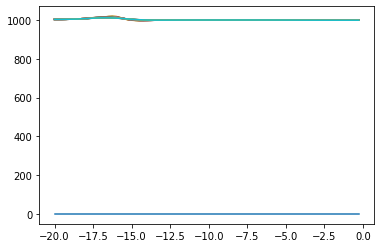

In [40]:
print('Plotting...')
#plt.plot(Um[:,1], z)
for i in range(len(nu_tm[0])):
    plt.plot(z, nu_tm[:,i])